In [318]:
import pathlib
import netCDF4
import pandas
import re
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm
import tqdm
import matplotlib.animation as manimation


%matplotlib inline


In [2]:
# convert all files
# for path in tqdm.tqdm_notebook(paths):
#     old_name = str(path)
#     new_name = str(path.parent / ('record_' + path.name))
#     !ncks --mk_rec_dmn time $old_name $new_name

In [3]:
name_re = re.compile(r'^record_.*_y(?P<year>\d{4})_m(?P<month>\d{2})\.nc$')
path = pathlib.Path('~/src/sealevelapp/data/tmp').expanduser()
paths = list(path.glob('record_*.nc'))

In [4]:
rows = []
for path in paths:    
    row = {'path': path}
    match = name_re.match(path.name)
    found = match.groupdict()
    row['month'] = int(found['month'])
    row['year'] = int(found['year'])
    rows.append(row)


In [11]:
df = pandas.DataFrame.from_records(rows)
df = df.sort_values(['year', 'month'])

KeyError: 'year'

In [8]:
to_merge = " ".join([str(x) for x in df['path'].apply(lambda x: x.relative_to('/Users/baart_f/src/sealevelapp/data/tmp'))])

In [12]:
ds = netCDF4.Dataset('/Users/baart_f/src/sealevelapp/data/tmp/merged.nc')
sla = ds.variables['sla'][:]
time = netCDF4.num2date(ds.variables['time'][:], ds.variables['time'].units)

In [13]:
lon = ds.variables['lon'][:]
lat = ds.variables['lat'][:]

KeyboardInterrupt: 

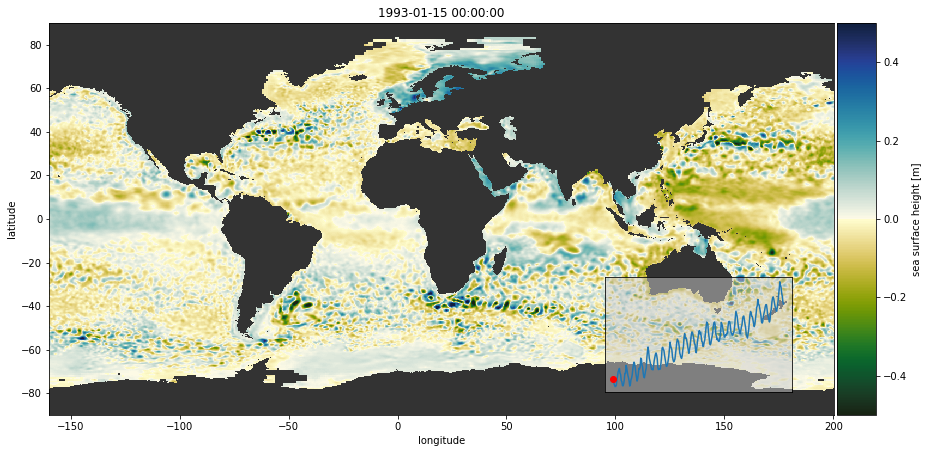

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(13, 8))

ax.set_facecolor((0.2, 0.2, 0.2))
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
sl = np.ma.hstack([sla[0,:,800:], sla[0,:,:800]])
im = ax.imshow(sl, cmap=cmocean.cm.delta_r, origin='top', vmin=-0.5, vmax=0.5, extent=(lon[800] - 360, lon[800], lat[0], lat[-1]))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, label='sea surface height [m]')
fig.tight_layout()
# inlay 
ax_in = plt.axes([0.65, 0.2, .2, .2], facecolor=(0.8, 0.8, 0.8, 0.5))
series = np.mean(sla, (1, 2))
ax_in.plot(time, series)
ax_in.xaxis.set_visible(False)
ax_in.yaxis.set_visible(False)
dot, = ax_in.plot(time[0], series[0], 'ro')

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(
    title='Movie Test', 
    artist='Matplotlib',
    comment='Movie support!'
)
writer = FFMpegWriter(fps=15, metadata=metadata)
with writer.saving(fig, "writer_test.mp4", 100):
    for i in range(time.shape[0]):
        ax.set_title(time[i])
        sl = np.ma.hstack([sla[i,:,800:], sla[i,:,:800]])
        im.set_data(sl)
        dot.set_data(time[i], series[i])
        writer.grab_frame()


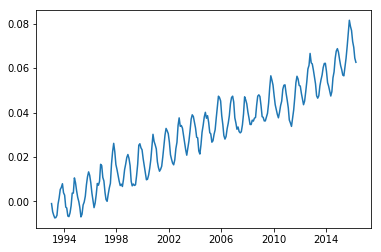

In [15]:
plt.plot(time, np.mean(sla, axis=(1, 2)))


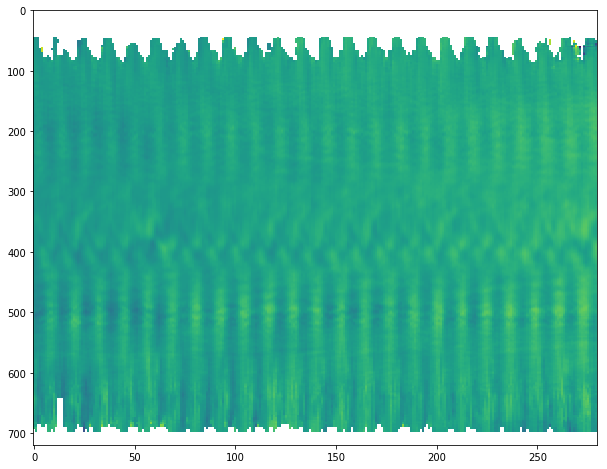

In [232]:
fig, ax = plt.subplots(figsize=(13,8))
ax.imshow(sla.mean(axis=2).T, aspect=0.3)

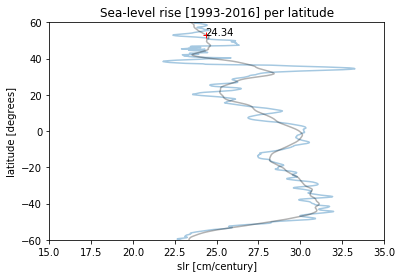

In [402]:
import statsmodels.regression
series_per_lat = sla.mean(axis=2)
# seconds * (hours/second)  * (days / hour) -> days
times = np.array([t.timestamp() * 1/3600.0 * 1/24.0 for t in time]) 
times -= times[0]
def fit(y):
    # no const (fit through 0)
    y = statsmodels.regression.linear_model.add_constant(y)
    fit = statsmodels.regression.linear_model.OLS(y, times).fit()
    # m/day * 365 day/year -> m / year  * (100/1, cm/m * 100/1 year/century) -> cm / century
    return fit.params[0][1] * 365 * 10000.0
trends = np.array([fit(series) for series in series_per_lat.T])
rolling_mean = pandas.Series(trends).rolling(window=20*2, center=True).mean()

fig, ax = plt.subplots()
ax.plot(trends, lat, alpha=0.4)
ax.plot(rolling_mean, lat, 'k-', alpha=0.3)
ax.set_ylim(-60, 60)
ax.set_xlim(15, 35)
ax.set_xlabel('slr [cm/century]')
ax.set_ylabel('latitude [degrees]')

(idx,) = np.nonzero(lat == 53.125)
ax.plot(rolling_mean[idx], 53.125, 'r+')
ax.text(rolling_mean[idx], 53.125, "%.2f" % (rolling_mean[idx], ))
ax.set_title('Sea-level rise [1993-2016] per latitude')

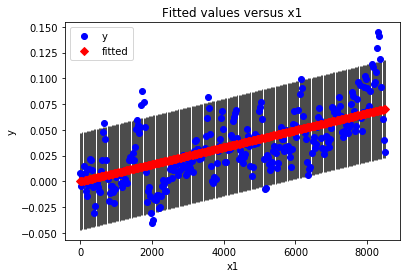

In [262]:
fit = statsmodels.regression.linear_model.OLS(series_per_lat[:, 360], times).fit()
fig, ax= plt.subplots()
_ = statsmodels.graphics.regressionplots.plot_fit(fit, 0, ax=ax)


In [172]:
ssh = sla.mean(axis=(1,2))
y = statsmodels.regression.linear_model.add_constant(ssh)
statsmodels.regression.linear_model.OLS(y, times).fit().params

array([[  7.61152179e-05,   2.63110492e-06]])

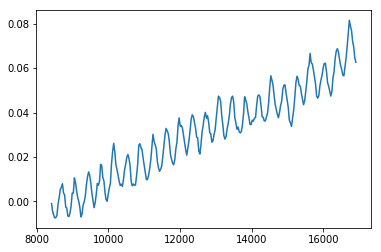

In [69]:
plt.plot(times, y[:,1])

In [98]:
import statsmodels.tsa
import pandas
index = pandas.date_range(time[0], periods=len(time), freq='M')
df = pandas.DataFrame(index=index, data=dict(ssh=sla.mean(axis=(1,2))))
model = statsmodels.tsa.seasonal.seasonal_decompose(df.ssh)

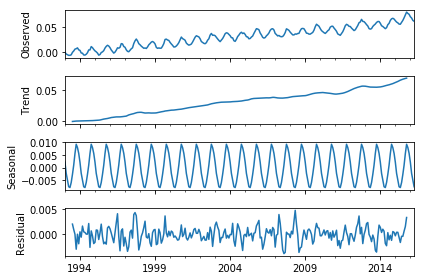

In [290]:
_ = model.plot()

In [320]:
sl = model.trend + model.resid
delta_sl = sl[-7] - sl[6]
delta_t = sl.index[-7] - sl.index[6]
delta_year = delta_t.total_seconds() / (24 * 3600 * 365.25)
(delta_sl * 100) / (delta_year/100)

31.887766206757931

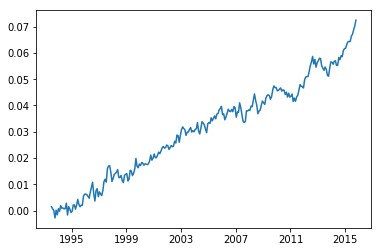

In [321]:
plt.plot(time, model.trend + model.resid)

In [416]:
fit = statsmodels.regression.linear_model.OLS(sl[6:-7], statsmodels.regression.linear_model.add_constant(np.c_[times[6:-7], times[6:-7]**2])).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ssh   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     6033.
Date:                Fri, 12 May 2017   Prob (F-statistic):          4.40e-221
Time:                        12:58:52   Log-Likelihood:                 1200.6
No. Observations:                 267   AIC:                            -2395.
Df Residuals:                     264   BIC:                            -2385.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0033      0.001     -6.110      0.000      -0.004      -0.002
x1          8.401e-06   2.94e-07     28.586      0.000    7.82e-06    8.98e-06
x2         -7.457e-11   3.37e-11     -2.211      0.028   -1.41e-10   -8.18e-12
==============================================================================
Omnibus:                        2.858   Durbin-Watson:                   0.382
Prob(Omnibus):                  0.240   Jarque-Bera (JB):                3.114
Skew:                          -0.008   Prob(JB):                        0.211
Kurtosis:                       3.529   Cond. No.                     1.01e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

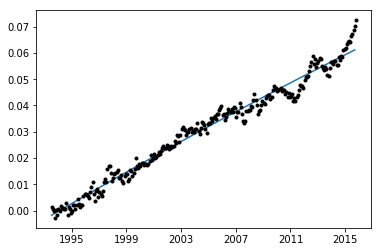

In [432]:
plt.plot(time[6:-7], fit.predict())
plt.plot(time, sl, 'k.')

In [387]:
index = pandas.date_range(time[0], periods=len(time), freq='M')

def decompose(series):
    df = pandas.DataFrame(index=index, data=dict(ssh=series))
    model = statsmodels.tsa.seasonal.seasonal_decompose(df.ssh)
    return model.trend 
decompositions = []
for series in series_per_lat[:, 90:-90].T:
    decomposed = decompose(series)
    decompositions.append(np.array(decomposed))
    
    
    


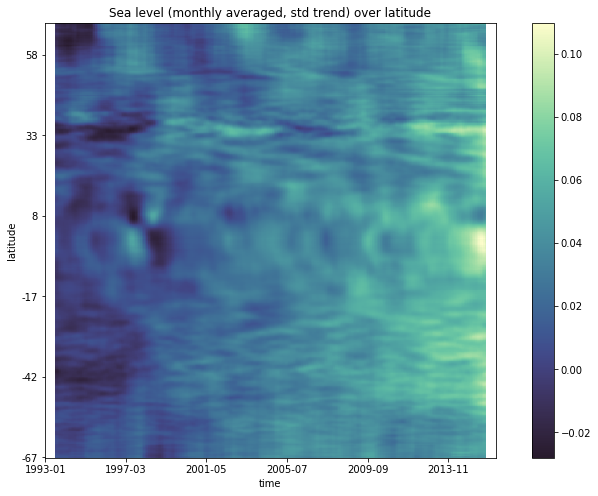

In [400]:
import matplotlib.cm
fig, ax = plt.subplots(figsize=(13, 8))
im = ax.imshow(np.vstack(decompositions), aspect=0.5, cmap=cmocean.cm.deep_r, origin='top')

xlabels = [
    time[loc].strftime('%Y-%m') if (loc >= 0 and loc < 300) else '' 
    for loc 
    in ax.xaxis.get_ticklocs().astype('int')
]
_ = ax.xaxis.set_ticklabels(xlabels)
ylabels = [
    "%.0f" % (lat[90:-90][loc], ) if loc < 540 else ''
    for loc 
    in ax.yaxis.get_ticklocs().astype('int')
]
y = ax.yaxis.set_ticklabels(ylabels)

ax.set_title('Sea level (monthly averaged, std trend) over latitude')
ax.set_xlabel('time')
ax.set_ylabel('latitude')
plt.colorbar(im, ax=ax)

In [367]:
a = time[0]
a.strftime('%Y-%m')

'1993-01'

In [407]:
np.apply_along_axis(lambda x: x.shape, 0, sla)

array([[[280, 280, 280, ..., 280, 280, 280],
        [280, 280, 280, ..., 280, 280, 280],
        [280, 280, 280, ..., 280, 280, 280],
        ..., 
        [280, 280, 280, ..., 280, 280, 280],
        [280, 280, 280, ..., 280, 280, 280],
        [280, 280, 280, ..., 280, 280, 280]]])